In [1]:
## Pacotes para abrir arquivos em pastas:
import os
import glob
import warnings
warnings.filterwarnings('ignore')

## Pacotes para arrumar os dados:
import math
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [2]:
### Pasta com os dataframes com as médias de minuto em minuto:
directory0 = '/mnt/HD_500GB_WD/00_Doutorado/Codigos_Notebooks_Medias_Resample/Dataframes_Media1m/'

### Variáveis de Nuvens:
CBH = pd.read_pickle(directory0+'clwacrbnd1kolliasM1_cloud_layer_base_height_layer_mais_baixa_detectada_df_T_dias_raw_1m.pkl')
CTH = pd.read_pickle(directory0+'clwacrbnd1kolliasM1_cloud_layer_top_height_layer_mais_baixa_detectada_df_T_dias_raw_1m.pkl')
# CBH = pd.read_pickle(directory0+'clwacrrwp1fengM1_cloud_layer_base_height_WACR_df_T_dias_raw_1m_dBZ.pkl')
# CBH = CBH*1000
# CTH = pd.read_pickle(directory0+'clwacrrwp1fengM1_cloud_layer_top_height_WACR_df_T_dias_raw_1m_dBZ.pkl')
# CTH = CTH*1000
LWP = pd.read_pickle(directory0+'ret1liljclouM1_be_lwp_df_T_dias_raw_1m_S2.pkl')

In [3]:
### Lista com todos os dataframes e lista com os nomes dos dataframes:
dataframes = [CBH, CTH, LWP]
nomes = ['CBH', 'CTH', 'LWP']

In [4]:
### Função para padronizar o formato do índice (minutos) e das datas nas colunas dos dataframes
### (padrão: '01/01/2015'):
def padroniza_datas(df):
    mins = np.arange(0, 1440, 1)
    datas = list(df.columns)
    datas_arrumadas = []
    for dia in datas:
        if len(dia)==10:
            datas_arrumadas.append(dia)
        elif len(dia)==8:
            ltemp = []
            for c in dia:
                ltemp.append(c)
            ltemp.insert(0,'0')
            ltemp.insert(3,'0')
            datas_arrumadas.append(''.join(ltemp))
        elif len(dia)==9 and dia[1]=='/':
            ltemp = []
            for c in dia:
                ltemp.append(c)
            ltemp.insert(0,'0')
            datas_arrumadas.append(''.join(ltemp))
        elif len(dia)==9 and dia[1]!='/':
            ltemp = []
            for c in dia:
                ltemp.append(c)
            ltemp.insert(3,'0')
            datas_arrumadas.append(''.join(ltemp))
    df.columns = datas_arrumadas
    df.index = mins
    df.index.name = "tempo"
    df.columns.name = "dias"

In [5]:
### Para todos os dataframes, aplicando a função padroniza_datas:
for df in dataframes:
    padroniza_datas(df)

In [6]:
### Função que lê as colunas do dataframe df e remove aquelas que só possuem NaN:
def corta_colunas_inteiras_com_nan(df):
    for col in df:
        if df[col].isnull().sum() == len(df[col]):
            df.drop(columns=col, inplace=True)
        else:
            pass

In [7]:
### Para cada dataframe aplicando a função que remove colunas que só têm NaN:
for df in dataframes:
    corta_colunas_inteiras_com_nan(df)

In [8]:
### Função que constrói um set (para cada dataframe) contendo os nomes não duplicados das colunas do df. Depois
### disso usa esses sets para achar a intersecção dos dias entre todos os df. Depois organizando a intersecção 
### em ordem crescente de datas. OBS: O objeto set é utilizado para fazer intersecção "&" ou 
### "set.intersection(*lista_de_sets)" de conjuntos matemáticos
def sets_interseccao(lista_ds):
    sets = []
    for ds in lista_ds:
        c = set(ds.columns)
        sets.append(c)
    colunas_intersec = list(set.intersection(*sets))
    colunas_intersec.sort(key = lambda data: datetime.strptime(data, '%d/%m/%Y'))
    return colunas_intersec

In [9]:
### Aplicando a função que retorna uma lista com as datas em comum já em ordem crescente:
colunas_interseccao = sets_interseccao(dataframes)

### Filtrando os dfs de acordo com os dias de intersecção comum entre eles:
lista = [CBH[colunas_interseccao], CTH[colunas_interseccao], LWP[colunas_interseccao]]

In [10]:
### Filtrando os dfs de acordo com o período diurno (das 06:00 às 18:00):
listadia = [lista[0].loc[359:1078], lista[1].loc[359:1078], lista[2].loc[359:1078]]

### Para cada dataframe aplicando a função que remove colunas que só têm NaN:
for df in listadia:
    corta_colunas_inteiras_com_nan(df)
    
### Aplicando a função que retorna uma lista com as datas em comum já em ordem crescente:
colunas_interseccaodia = sets_interseccao(listadia)

### Filtrando os dfs de acordo com os dias de intersecção comum entre eles:
listadia2 = [listadia[0][colunas_interseccaodia], listadia[1][colunas_interseccaodia], 
             listadia[2][colunas_interseccaodia]]

In [12]:
### Para cada minuto e coluna comum entre os dataframes de CBH, CTH e LWP calculando a extensão 
### vertical (z) da nuvem = CTH-CBH e construindo um dataframe:
dicz = {}
for col in listadia2[0].columns:
    z = listadia2[1][col]-listadia2[0][col]
    dicz.update({col:z})
df_z = pd.DataFrame(dicz)
df_z

,18/02/2014,21/02/2014,22/02/2014,23/02/2014,24/02/2014,26/02/2014,02/03/2014,03/03/2014,04/03/2014,06/03/2014,...,21/11/2015,22/11/2015,23/11/2015,24/11/2015,25/11/2015,26/11/2015,27/11/2015,28/11/2015,29/11/2015,30/11/2015
tempo,,,,,,,,,,,,,,,,,,,,,
359,NaN,3377.661621,2688.139160,304.789062,NaN,239.833984,5518.679688,202.359924,1586.401611,NaN,...,641.554688,NaN,NaN,NaN,NaN,459.681763,1176.685059,3642.477539,NaN,NaN
360,NaN,3525.059814,2578.215332,329.771484,NaN,239.833984,5728.534180,457.183472,1623.875732,NaN,...,NaN,NaN,NaN,4676.762207,NaN,2450.803467,1054.270020,3777.383789,NaN,NaN
361,NaN,3527.558105,2538.242188,329.771484,NaN,254.823486,5093.973633,499.654144,1508.955322,NaN,...,NaN,NaN,659.545898,5002.786621,NaN,2935.468018,984.318359,2158.506836,1948.650391,NaN
362,NaN,3367.668701,2853.024414,329.771484,44.968750,239.833984,4516.873047,562.110840,1216.657959,NaN,...,1239.142578,NaN,764.470703,NaN,NaN,1706.318848,879.391113,1439.003906,1169.191406,NaN
363,NaN,2765.585449,4551.848145,439.695312,112.422363,239.833984,4456.915039,559.612549,1151.702881,NaN,...,1184.179688,NaN,649.550781,NaN,NaN,1316.588623,524.636230,1439.003906,1066.761719,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,NaN,6465.523926,10622.645508,10587.668945,1034.283691,6398.070801,5868.437500,NaN,1321.585205,NaN,...,242.332031,252.682251,NaN,4207.087891,567.107361,1314.090332,164.885986,489.662109,NaN,342.263062
1075,492.516113,6485.509766,11059.842773,10577.676758,397.224976,6070.797363,5803.981934,NaN,1921.170166,NaN,...,319.778320,349.757935,NaN,2892.997070,1081.751221,1251.633301,NaN,509.647095,NaN,617.072876
1076,44.968750,6433.046387,11114.804688,9988.084961,1696.326172,5731.032227,5778.500000,NaN,1788.761963,NaN,...,213.185547,389.730225,NaN,337.266479,1021.792664,1076.754883,NaN,689.522705,NaN,559.612549


In [13]:
### Para cada minuto e coluna comum entre os dataframes de z e LWP calculando o conteúdo de água líquida
### (LWC) da nuvem = LWP/z e construindo um dataframe:
diclwc = {}
for col in df_z.columns:
    lwc = listadia2[2][col]/df_z[col]
    diclwc.update({col:lwc})
df_lwc = pd.DataFrame(diclwc)
df_lwc

,18/02/2014,21/02/2014,22/02/2014,23/02/2014,24/02/2014,26/02/2014,02/03/2014,03/03/2014,04/03/2014,06/03/2014,...,21/11/2015,22/11/2015,23/11/2015,24/11/2015,25/11/2015,26/11/2015,27/11/2015,28/11/2015,29/11/2015,30/11/2015
tempo,,,,,,,,,,,,,,,,,,,,,
359,NaN,NaN,-0.002777,0.123360,NaN,0.036785,NaN,0.758415,0.100899,NaN,...,0.043884,NaN,NaN,NaN,NaN,NaN,0.060524,0.005115,NaN,NaN
360,NaN,NaN,-0.003371,0.135454,NaN,0.048751,NaN,0.370443,0.081630,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.065734,0.002811,NaN,NaN
361,NaN,0.145694,-0.000283,0.135957,NaN,0.055989,NaN,0.346467,0.128683,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.062415,NaN,NaN,NaN
362,NaN,0.169105,0.000344,0.103370,NaN,0.078823,NaN,0.295284,0.172321,NaN,...,0.027990,NaN,0.008426,NaN,NaN,NaN,0.072771,0.022710,-0.001159,NaN
363,NaN,0.130965,-0.001253,0.090761,NaN,0.054693,NaN,0.292805,0.181620,NaN,...,0.018895,NaN,NaN,NaN,NaN,NaN,0.160816,0.014390,0.006787,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,NaN,-0.000512,0.040898,NaN,0.032261,NaN,0.143071,NaN,0.151405,NaN,...,0.003365,NaN,NaN,0.001411,NaN,0.005586,NaN,0.009869,NaN,0.305427
1075,NaN,-0.000424,0.037531,NaN,0.088122,NaN,0.131349,NaN,0.099372,NaN,...,NaN,0.073067,NaN,0.003913,NaN,NaN,NaN,0.015369,NaN,0.476831
1076,0.046209,-0.000377,0.034939,NaN,0.017801,NaN,0.120017,NaN,0.104085,NaN,...,0.002006,0.050353,NaN,0.043264,NaN,NaN,NaN,0.012735,NaN,0.260420


In [14]:
### Para cada minuto e coluna do dataframe "df_lwc" calculando o conteúdo de água líquida "calibrado"
### (LWC_cal) da nuvem: LWC_cal = (0.95*LWC)-0.02 OU LWC_cal=(0.92*LWC) e construindo um dataframe:
diclwccal = {}
for col in df_lwc.columns:
    lwccal = df_lwc[col]
#     lwccal = (0.95*df_lwc[col])-0.02
#     lwccal = (0.92*df_lwc[col])
    diclwccal.update({col:lwccal})
df_lwc_cal = pd.DataFrame(diclwccal)
df_lwc_cal

,18/02/2014,21/02/2014,22/02/2014,23/02/2014,24/02/2014,26/02/2014,02/03/2014,03/03/2014,04/03/2014,06/03/2014,...,21/11/2015,22/11/2015,23/11/2015,24/11/2015,25/11/2015,26/11/2015,27/11/2015,28/11/2015,29/11/2015,30/11/2015
tempo,,,,,,,,,,,,,,,,,,,,,
359,NaN,NaN,-0.002777,0.123360,NaN,0.036785,NaN,0.758415,0.100899,NaN,...,0.043884,NaN,NaN,NaN,NaN,NaN,0.060524,0.005115,NaN,NaN
360,NaN,NaN,-0.003371,0.135454,NaN,0.048751,NaN,0.370443,0.081630,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.065734,0.002811,NaN,NaN
361,NaN,0.145694,-0.000283,0.135957,NaN,0.055989,NaN,0.346467,0.128683,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.062415,NaN,NaN,NaN
362,NaN,0.169105,0.000344,0.103370,NaN,0.078823,NaN,0.295284,0.172321,NaN,...,0.027990,NaN,0.008426,NaN,NaN,NaN,0.072771,0.022710,-0.001159,NaN
363,NaN,0.130965,-0.001253,0.090761,NaN,0.054693,NaN,0.292805,0.181620,NaN,...,0.018895,NaN,NaN,NaN,NaN,NaN,0.160816,0.014390,0.006787,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,NaN,-0.000512,0.040898,NaN,0.032261,NaN,0.143071,NaN,0.151405,NaN,...,0.003365,NaN,NaN,0.001411,NaN,0.005586,NaN,0.009869,NaN,0.305427
1075,NaN,-0.000424,0.037531,NaN,0.088122,NaN,0.131349,NaN,0.099372,NaN,...,NaN,0.073067,NaN,0.003913,NaN,NaN,NaN,0.015369,NaN,0.476831
1076,0.046209,-0.000377,0.034939,NaN,0.017801,NaN,0.120017,NaN,0.104085,NaN,...,0.002006,0.050353,NaN,0.043264,NaN,NaN,NaN,0.012735,NaN,0.260420


In [15]:
### A partir das strings em cada coluna separando os que terminam em "2014", colocando essas strings em uma
### lista e usando essa lista para filtrar somente as colunas de 2014 no "df_lwc_cal":
colunas14, colunas15 = [], []
for col in df_lwc_cal.columns:
    if str(col).split('/')[-1] == '2014':
        colunas14.append(str(col))
    else:
        colunas15.append(str(col))

df_lwc_cal2015 = df_lwc_cal[colunas15]

In [16]:
#####################################################################

In [17]:
pasta_dias_estacoes = '/mnt/HD_500GB_WD/historia2/Analises_Aerossois/'
l15 = pd.read_pickle(pasta_dias_estacoes+'diaslimpa15.pkl')
p15 = pd.read_pickle(pasta_dias_estacoes+'diaspoluida15.pkl')
t15_1 = pd.read_pickle(pasta_dias_estacoes+'diastransicao15_1.pkl')

In [18]:
### Separando em estações limpa/chuvosa, poluída/seca e transições:
limpa, poluida, trans1 = [], [], []
for col in df_lwc_cal2015.columns:
    if col in l15.columns:
        limpa.append(col)
    elif col in p15.columns:
        poluida.append(col)
    elif col in t15_1.columns:
        trans1.append(col)
df_lwc_cal2015_limpa = df_lwc_cal2015[limpa]
df_lwc_cal2015_poluida = df_lwc_cal2015[poluida]
df_lwc_cal2015_trans1 = df_lwc_cal2015[trans1]

In [20]:
### Para cada minuto e coluna dos dataframes "df_lwc_cal2014_limpa", "df_lwc_cal2014_poluida",
### "df_lwc_cal2014_trans1", "df_lwc_cal2014_trans2", "df_lwc_cal2014_trans3" e "df_lwc_cal2014_trans4"
### calculando os reff segundo as equações arccosh que achei através dos dados do avião:
# ### Transição 1 - Não tem dias...:
# dicreff14trans1 = {}
# p1dia = 100/len(df_lwc_cal2014_trans1.columns)
# p = np.linspace(p1dia, 100.0, len(df_lwc_cal2014_trans1.columns)+1)
# pctsa = list(p/100)[:-1]
# pctsb = [1-v for v in pctsa]
# for i, col in enumerate(df_lwc_cal2014_trans1.columns):
#     reffl = (8.31) + (8.2)*np.arccosh(1+df_lwc_cal2014_trans1[col])
#     reffp = (1.32) + (5.84)*np.arccosh(1+df_lwc_cal2014_trans1[col])
#     reff = (pctsb[i]*reffp)+(pctsa[i]*reffl)
#     print(i, pctsa[i], pctsb[i])
#     dicreff14trans1.update({col:reff})
# df_reff2014_trans1 = pd.DataFrame(dicreff14trans1)

### Limpa:
dicreff15limpa = {}
for col in df_lwc_cal2015_limpa:
    reff1 = (8.31) + (8.2)*np.arccosh(1+df_lwc_cal2015_limpa[col])
    dicreff15limpa.update({col:reff1})
df_reff2015_limpa = pd.DataFrame(dicreff15limpa)

### Transição:
dicreff15trans1 = {}
p1dia = 100/len(df_lwc_cal2015_trans1.columns)
p = np.linspace(p1dia, 100.0, len(df_lwc_cal2015_trans1.columns)+1)
pctssobe = list(p/100)[:-1]
pctsdesce = [1-v for v in pctssobe]
for i, col in enumerate(df_lwc_cal2015_trans1.columns):
    reffl = (8.31) + (8.2)*np.arccosh(1+df_lwc_cal2015_trans1[col])
    reffp = (1.32) + (5.84)*np.arccosh(1+df_lwc_cal2015_trans1[col])
    reff = (pctsdesce[i]*reffl)+(pctssobe[i]*reffp)
#     print(i, pctsdesce[i], pctssobe[i])
    dicreff15trans1.update({col:reff})
df_reff2015_trans1 = pd.DataFrame(dicreff15trans1)

### Poluída:
dicreff15poluida = {}
for col in df_lwc_cal2015_poluida:
    reff2 = (1.32) + (5.84)*np.arccosh(1+df_lwc_cal2015_poluida[col])
    dicreff15poluida.update({col:reff2})
df_reff2015_poluida = pd.DataFrame(dicreff15poluida)

In [21]:
### Fazendo uma lista com os dataframes de cbh, cth, z, lwp, lwc, 
### lwc_calibrado e reff para o período limpo e outra para o
### período poluído:
dfs_limpa15 = [listadia2[0][limpa], listadia2[1][limpa], 
               df_z[limpa], listadia2[2][limpa], df_lwc[limpa],
               df_lwc_cal2015_limpa, df_reff2015_limpa]
dfs_poluida15 = [listadia2[0][poluida], listadia2[1][poluida], 
                 df_z[poluida], listadia2[2][poluida],
                 df_lwc[poluida], df_lwc_cal2015_poluida,
                 df_reff2015_poluida]
dfs_trans1_15 = [listadia2[0][trans1], listadia2[1][trans1], 
                 df_z[trans1], listadia2[2][trans1],
                 df_lwc[trans1], df_lwc_cal2015_trans1,
                 df_reff2015_trans1]

In [22]:
### Para cada dia do período limpo faço um dataframe e depois guardo 
### eles todos na lista "dataframes_diarios_limpa_2015": 
dataframes_diarios_limpa_2015 = []
for i in range(len(dfs_limpa15[0].columns)):
    lista_string_dia = []
    for j in range(len(dfs_limpa15[0][dfs_limpa15[0].columns[i]])):
        lista_string_dia.append(dfs_limpa15[0].columns[i])
    dic = {}
    dic.update({'dia':lista_string_dia})
    dic.update({'cbh':dfs_limpa15[0][dfs_limpa15[0].columns[i]]})
    dic.update({'cth':dfs_limpa15[1][dfs_limpa15[1].columns[i]]})
    dic.update({'z':dfs_limpa15[2][dfs_limpa15[2].columns[i]]})
    dic.update({'lwp':dfs_limpa15[3][dfs_limpa15[3].columns[i]]})
    dic.update({'lwc':dfs_limpa15[4][dfs_limpa15[4].columns[i]]})
    dic.update({'lwc_calibrado':dfs_limpa15[5][dfs_limpa15[5].columns[i]]})
    dic.update({'reff':dfs_limpa15[6][dfs_limpa15[6].columns[i]]})
    dataframe = pd.DataFrame(dic)
    dataframes_diarios_limpa_2015.append(dataframe)

### Para cada dia do período poluído faço um dataframe e depois
### guardo eles todos na lista "dataframes_diarios_poluida_2015": 
dataframes_diarios_poluida_2015 = []
for i in range(len(dfs_poluida15[0].columns)):
    lista_string_dia = []
    for j in range(len(dfs_poluida15[0][dfs_poluida15[0].columns[i]])):
        lista_string_dia.append(dfs_poluida15[0].columns[i])
    dic = {}
    dic.update({'dia':lista_string_dia})
    dic.update({'cbh':dfs_poluida15[0][dfs_poluida15[0].columns[i]]})
    dic.update({'cth':dfs_poluida15[1][dfs_poluida15[1].columns[i]]})
    dic.update({'z':dfs_poluida15[2][dfs_poluida15[2].columns[i]]})
    dic.update({'lwp':dfs_poluida15[3][dfs_poluida15[3].columns[i]]})
    dic.update({'lwc':dfs_poluida15[4][dfs_poluida15[4].columns[i]]})
    dic.update({'lwc_calibrado':dfs_poluida15[5][dfs_poluida15[5].columns[i]]})
    dic.update({'reff':dfs_poluida15[6][dfs_poluida15[6].columns[i]]})
    dataframe = pd.DataFrame(dic)
    dataframes_diarios_poluida_2015.append(dataframe)

### Para cada dia do período trans1 faço um dataframe e depois
### guardo eles todos na lista "dataframes_diarios_trans2_2015": 
dataframes_diarios_trans1_2015 = []
for i in range(len(dfs_trans1_15[0].columns)):
    lista_string_dia = []
    for j in range(len(dfs_trans1_15[0][dfs_trans1_15[0].columns[i]])):
        lista_string_dia.append(dfs_trans1_15[0].columns[i])
    dic = {}
    dic.update({'dia':lista_string_dia})
    dic.update({'cbh':dfs_trans1_15[0][dfs_trans1_15[0].columns[i]]})
    dic.update({'cth':dfs_trans1_15[1][dfs_trans1_15[1].columns[i]]})
    dic.update({'z':dfs_trans1_15[2][dfs_trans1_15[2].columns[i]]})
    dic.update({'lwp':dfs_trans1_15[3][dfs_trans1_15[3].columns[i]]})
    dic.update({'lwc':dfs_trans1_15[4][dfs_trans1_15[4].columns[i]]})
    dic.update({'lwc_calibrado':dfs_trans1_15[5][dfs_trans1_15[5].columns[i]]})
    dic.update({'reff':dfs_trans1_15[6][dfs_trans1_15[6].columns[i]]})
    dataframe = pd.DataFrame(dic)
    dataframes_diarios_trans1_2015.append(dataframe)

In [23]:
print(len(dataframes_diarios_limpa_2015))
print('-----------')
print(len(dataframes_diarios_trans1_2015))
print('-----------')
print(len(dataframes_diarios_poluida_2015))

192
-----------
51
-----------
65


In [24]:
indices = [51, 109, 110]
lll = []
for i in indices:
    lista = list(dataframes_diarios_limpa_2015[i]['reff'])
    for v in lista:
        if v > 0 and math.isinf(v) == False:
            lll.append(v)
print(np.nanmean(lll))

11.76833080433421


In [25]:
media_reff_referencia_limpo_clusters = (11.754295833832137+np.nanmean(lll))/2
media_reff_referencia_limpo_clusters

11.761313319083174

In [41]:
((14.3 - media_reff_referencia_limpo_clusters)/media_reff_referencia_limpo_clusters)*100

21.585061226093792

In [44]:
((14.2 - media_reff_referencia_limpo_clusters)/media_reff_referencia_limpo_clusters)*100

20.734816042694522

In [26]:
((6.89 - 5.6)/6.89)*100

18.72278664731495

In [25]:
###########################################################

In [26]:
### Para cada uma das estações/períodos de 2015 filtrando as nuvens estratiformes 
### (LWC entre 0.2 e 0.4; CTH menor ou igual a 3 km) e juntando todos os LWC (reff) de todos os dias 
### (da estação em questão) em uma lista só:
## Limpa:
lwcs_limpa, refs_limpa = [], []
for df in dataframes_diarios_limpa_2015:
    stratus = df[(df['lwc']>=0.2) & (df['lwc']<=0.4) & (df['cth']<=3000.0)]
    listando_lwc = list(stratus['lwc'].values)
    listando_ref = list(stratus['reff'].values)
    for l in listando_lwc:
        lwcs_limpa.append(l)
    for r in listando_ref:
        refs_limpa.append(r)
print('Limpa:')
print(len(lwcs_limpa))
print(len(refs_limpa))
print('---------')
## Trans1:
lwcs_trans1, refs_trans1 = [], []
for df in dataframes_diarios_trans1_2015:
    stratus = df[(df['lwc']>=0.2) & (df['lwc']<=0.4) & (df['cth']<=3000.0)]
    listando_lwc = list(stratus['lwc'].values)
    listando_ref = list(stratus['reff'].values)
    for l in listando_lwc:
        lwcs_trans1.append(l)
    for r in listando_ref:
        refs_trans1.append(r)
print('Trans1:')
print(len(lwcs_trans1))
print(len(refs_trans1))
print('---------')
## Poluída:
lwcs_poluida, refs_poluida = [], []
for df in dataframes_diarios_poluida_2015:
    stratus = df[(df['lwc']>=0.2) & (df['lwc']<=0.4) & (df['cth']<=3000.0)]
    listando_lwc = list(stratus['lwc'].values)
    listando_ref = list(stratus['reff'].values)
    for l in listando_lwc:
        lwcs_poluida.append(l)
    for r in listando_ref:
        refs_poluida.append(r)
print('Poluída:')
print(len(lwcs_poluida))
print(len(refs_poluida))
print('---------')

Limpa:
6999
6999
---------
Trans1:
619
619
---------
Poluída:
1508
1508
---------


In [27]:
### Função para plotar histogramas e boxplots (na horizontal, acima do histograma) p/ cada período de 2014: 
def histogramas_boxplots(estacao, dados1, dados2, cores):
    stats1 = [np.nanmean(dados1), np.nanmedian(dados1), np.percentile(dados1, 25), np.percentile(dados1, 75)]
    stats2 = [np.nanmean(dados2), np.nanmedian(dados2), np.percentile(dados2, 25), np.percentile(dados2, 75)]
    tf = 12
    ax1 = plt.axes([.1, 0.85, .8, .22])
    ax2 = plt.axes([.1, .1, .8, .8])
    ax3 = plt.axes([1.05, 0.85, .8, .22])
    ax4 = plt.axes([1.05, 0.1, .8, .8])
    axes = [ax1, ax2, ax3, ax4]
    for i in range(len(axes)):
        if i==1:
            axes[i].set_ylim([0.0, 0.2])
            axes[i].set_xlim([0.19, 0.41])
        elif i==0:
            axes[i].set_xlim([0.19, 0.41])
        elif i==3:
            axes[i].set_ylim([0.0, 0.45])
            axes[i].set_xlim([4.0, 18.0])
        elif i==2:
            axes[i].set_xlim([4.0, 18.0])
    ####################### Boxplot LWC:
    bplots = axes[0].boxplot(dados1, vert=0, patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                             meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                             medianprops=dict(color='green', linewidth=1.7),
                             whiskerprops=dict(color=cores[1], linewidth=1.5),
                             capprops=dict(color=cores[1], linewidth=1.5))
    axes[0].axis('off')
    for i, bplot in enumerate(bplots['boxes']):
        bplot.set(color=cores[1], linewidth=1.5, alpha=1)
        bplot.set(facecolor=cores[0], alpha=0.6)
    ####################### Histograma LWC:
    axes[1].grid(True, axis='y', zorder=0, linestyle=':', color='dimgray')
    axes[1].set_xlabel(r'LWC (g/m³)', fontsize=tf)
    axes[1].set_ylabel('Frequência relativa', fontsize=tf)
    axes[1].tick_params(labelsize=tf)
    sns.histplot(data=dados1, ax=axes[1], color=cores[0], stat='probability', edgecolor=cores[1],
                 binwidth=0.02, linewidth=1.2, element="step", binrange=[0.2, 0.4], kde=False, alpha=0.6)
    axes[1].yaxis.set_major_locator(ticker.MultipleLocator(0.02))
    axes[1].xaxis.set_major_locator(ticker.MultipleLocator(0.02))
    if stats1[0] > stats1[1]:
        axes[1].axvline(x=stats1[2],color='gray',  linestyle='-.',lw=1.7,label='25%   = {0:.3f}'.format(stats1[2]))
        axes[1].axvline(x=stats1[1],color='green', linestyle='-',lw=1.7,label='50%   = {0:.3f}'.format(stats1[1]))
        axes[1].axvline(x=stats1[0],color='red',   linestyle='--',lw=1.7,label='Média = {0:.3f}'.format(stats1[0]))
        axes[1].axvline(x=stats1[3],color='gray',  linestyle='-.',lw=1.7,label='75%   = {0:.3f}'.format(stats1[3]))
    elif stats1[0] < stats1[1]:
        axes[1].axvline(x=stats1[2],color='gray',  linestyle='-.',lw=1.7,label='25%   = {0:.3f}'.format(stats1[2]))
        axes[1].axvline(x=stats1[0],color='red',   linestyle='--',lw=1.7,label='Média = {0:.3f}'.format(stats1[0]))
        axes[1].axvline(x=stats1[1],color='green', linestyle='-',lw=1.7,label='50%   = {0:.3f}'.format(stats1[1]))
        axes[1].axvline(x=stats1[3],color='gray',  linestyle='-.',lw=1.7,label='75%   = {0:.3f}'.format(stats1[3]))
    axes[1].legend(loc='upper right', frameon=True, fontsize=tf-1.5, ncol=1, fancybox=True, shadow=True)
    plt.setp(axes[1].get_xticklabels(), rotation=45, horizontalalignment='center', fontsize=tf, color='black')
    plt.setp(axes[1].get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf, color='black')

    ####################### Boxplot reff:
    bplots = axes[2].boxplot(dados2, vert=0, patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                             meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                             medianprops=dict(color='green', linewidth=1.7),
                             whiskerprops=dict(color=cores[3], linewidth=1.5),
                             capprops=dict(color=cores[3], linewidth=1.5))
    axes[2].axis('off')
    for i, bplot in enumerate(bplots['boxes']):
        bplot.set(color=cores[3], linewidth=1.5, alpha=1)
        bplot.set(facecolor=cores[2], alpha=0.6)
    ####################### Histograma reff:
    axes[3].grid(True, axis='y', zorder=0, linestyle=':', color='dimgray')
    axes[3].set_xlabel('$r_{eff}$ ($\mu$m)', fontsize=tf)
    axes[3].set_ylabel('Frequência relativa', fontsize=tf)
    axes[3].tick_params(labelsize=tf)
    sns.histplot(data=dados2, ax=axes[3], color=cores[2], stat='probability', edgecolor=cores[3],
                 binwidth=0.5, linewidth=1.2, element="step", binrange=[4.0, 18.0], kde=False, alpha=0.6)
    axes[3].yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    axes[3].xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    if stats2[0] > stats2[1]:
        axes[3].axvline(x=stats2[2],color='gray',  linestyle='-.',lw=1.7,label='25%   = {0:.1f}'.format(stats2[2]))
        axes[3].axvline(x=stats2[1],color='green', linestyle='-',lw=1.7,label='50%   = {0:.1f}'.format(stats2[1]))
        axes[3].axvline(x=stats2[0],color='red',   linestyle='--',lw=1.7,label='Média = {0:.1f}'.format(stats2[0]))
        axes[3].axvline(x=stats2[3],color='gray',  linestyle='-.',lw=1.7,label='75%   = {0:.1f}'.format(stats2[3]))
    elif stats2[0] < stats2[1]:
        axes[3].axvline(x=stats2[2],color='gray',  linestyle='-.',lw=1.7,label='25%   = {0:.1f}'.format(stats2[2]))
        axes[3].axvline(x=stats2[0],color='red',   linestyle='--',lw=1.7,label='Média = {0:.1f}'.format(stats2[0]))
        axes[3].axvline(x=stats2[1],color='green', linestyle='-',lw=1.7,label='50%   = {0:.1f}'.format(stats2[1]))
        axes[3].axvline(x=stats2[3],color='gray',  linestyle='-.',lw=1.7,label='75%   = {0:.1f}'.format(stats2[3]))
    axes[3].legend(loc='best', frameon=True, fontsize=tf-1.5, ncol=1, fancybox=True, shadow=True)
    plt.setp(axes[3].get_xticklabels(), rotation=45, horizontalalignment='center', fontsize=tf, color='black')
    plt.setp(axes[3].get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf, color='black')

    ####################### Título:
    axes[0].text(x=0.41, y=1.42, s=estacao, fontsize=tf+2)
    plt.tight_layout()
#     plt.show()
    if estacao == 'Limpo':
        plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/HistsLWCReff_Limpo_2015.png',
                    dpi=400, bbox_inches='tight', facecolor='white')
    elif estacao == 'Transição':
        plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/HistsLWCReff_Trans_2015.png',
                    dpi=400, bbox_inches='tight', facecolor='white')
    elif estacao == 'Poluído':
        plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/HistsLWCReff_Poluido_2015.png',
                    dpi=400, bbox_inches='tight', facecolor='white')

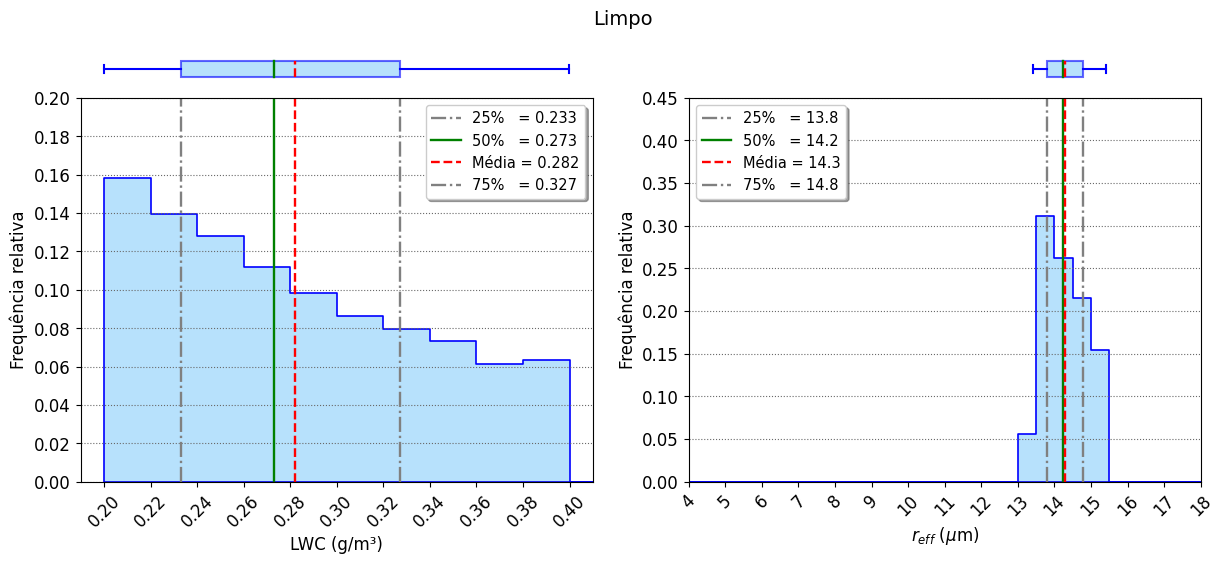

In [28]:
################################################################################# LIMPA:
histogramas_boxplots('Limpo', lwcs_limpa, refs_limpa, ['lightskyblue', 'blue', 'lightskyblue', 'blue'])

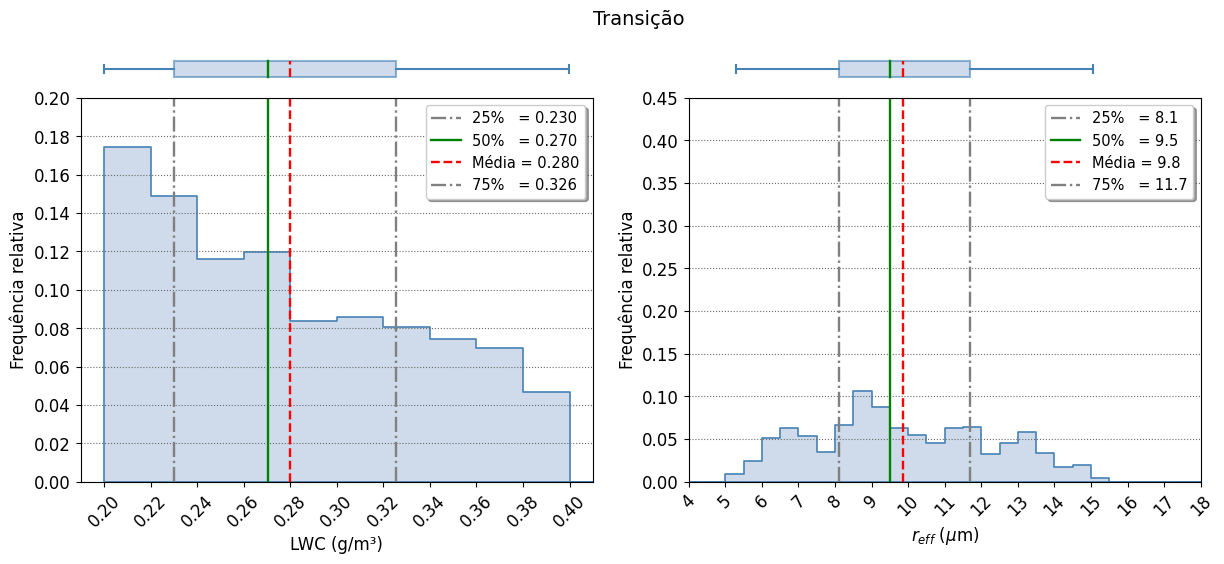

In [29]:
################################################################################# TRANSIÇÃO:
histogramas_boxplots('Transição', lwcs_trans1, refs_trans1, 
                     ['lightsteelblue', 'steelblue', 'lightsteelblue', 'steelblue'])

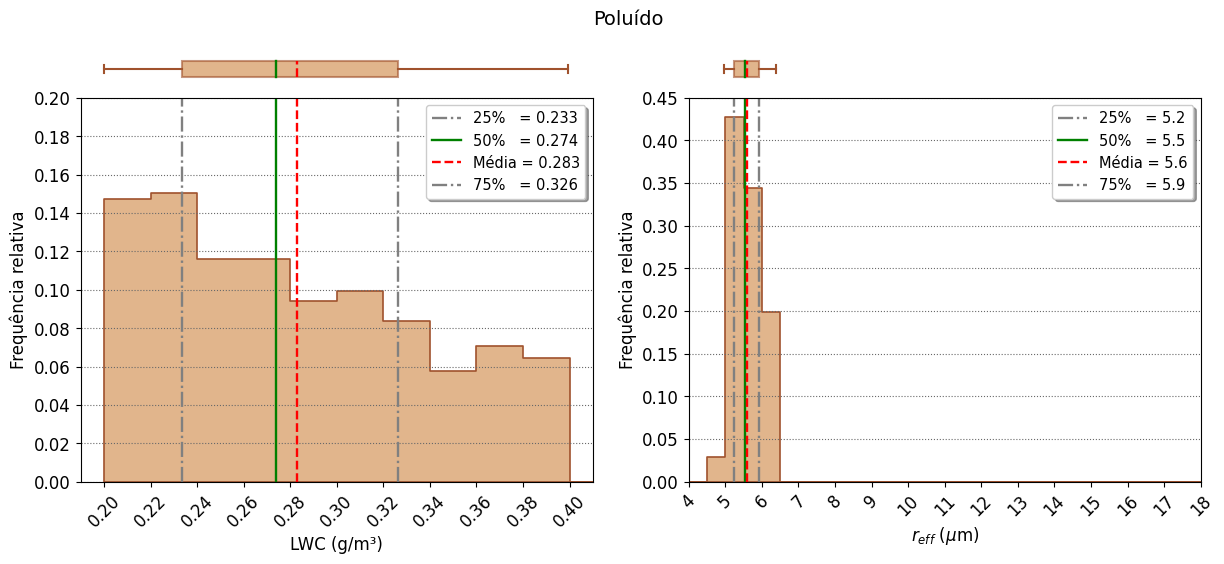

In [30]:
################################################################################# POLUÍDA:
histogramas_boxplots('Poluído', lwcs_poluida, refs_poluida, 
                     ['peru', 'sienna', 'peru', 'sienna'])

In [31]:
dias_limpa15 = []
for df in dataframes_diarios_limpa_2015:
    dias_limpa15.append(df['dia'].iloc[0])
dias_poluida15 = []
for df in dataframes_diarios_poluida_2015:
    dias_poluida15.append(df['dia'].iloc[0])
dias_trans1_15 = []
for df in dataframes_diarios_trans1_2015:
    dias_trans1_15.append(df['dia'].iloc[0])

In [32]:
### Convertendo os dataframes finais para ".pkl" (tipo pikcle) e salvando eles numa pasta:
# directory = '/media/andre/SAMSUNG/03_HD_500GB_WD/historia2/Tabelas_passo9/comtr-2015/'
# directory = '/mnt/HD_500GB_WD/historia2/Tabelas_passo9/comtr-medianas-2015/'
directory = '/mnt/HD_500GB_WD/historia2/Tabelas_passo9/comtr-medianas-2015-final/'

######################### Dias limpos:
for i, df in enumerate(dataframes_diarios_limpa_2015):
    dia = dias_limpa15[i]
    name = dia.split('/')[0]+'_'+dia.split('/')[1]+'_'+dia.split('/')[2]
    if i < 10:
        df.to_pickle(directory+'limpos/'+'df_nuvenspasso9_0{0}_limpa_{1}.pkl'.format(i, name))
    else:
        df.to_pickle(directory+'limpos/'+'df_nuvenspasso9_{0}_limpa_{1}.pkl'.format(i, name))

######################### Dias poluídos:
for i, df in enumerate(dataframes_diarios_poluida_2015):
    dia = dias_poluida15[i]
    name = dia.split('/')[0]+'_'+dia.split('/')[1]+'_'+dia.split('/')[2]
    if i < 10:
        df.to_pickle(directory+'poluidos/'+'df_nuvenspasso9_0{0}_poluida_{1}.pkl'.format(i, name))
    else:
        df.to_pickle(directory+'poluidos/'+'df_nuvenspasso9_{0}_poluida_{1}.pkl'.format(i, name))
        
######################### Dias trans1:
for i, df in enumerate(dataframes_diarios_trans1_2015):
    dia = dias_trans1_15[i]
    name = dia.split('/')[0]+'_'+dia.split('/')[1]+'_'+dia.split('/')[2]
    if i < 10:
        df.to_pickle(directory+'trans1/'+'df_nuvenspasso9_0{0}_trans1_{1}.pkl'.format(i, name))
    else:
        df.to_pickle(directory+'trans1/'+'df_nuvenspasso9_{0}_trans1_{1}.pkl'.format(i, name))